In [1]:
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
import numpy as np
import jax.numpy as jnp
from jax import random
from jax import vmap
import matplotlib.pyplot as plt
import pandas as pd

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# GOH
Gasser et al 2006(https://doi.org/10.1098/rsif.2005.0073)


Incompressible material assumption
$$\Psi_1(J) = p(1-J)$$
$$\Psi_2(\mathbf{C}) = \frac{\mu}{2}(I_1 -3) +\frac{k_1}{2k_2}[e^{(k_2[\kappa I_1 + (1-3\kappa)I_4-1]^2)}-1]$$
Here $I_4 = \mathbf{C}:\mathbf{M} =\mathbf{C}:  \mathbf{a}_0\otimes \mathbf{a}_0$

Let $\mathbf{H} =\kappa \mathbf{I} + (1-3\kappa)\mathbf{M}$ 

and $H = \mathbf{H}:\mathbf{C}  =\kappa I_1 + (1-3\kappa)I_4$ and $E = [{H}-1]$

$$\mathbf{S}_1  = 2\frac{\partial \Psi_{1}}{\partial \mathbf{C}} = -pC^{-1} $$
$$\mathbf{S}_2  =  2\frac{\partial \Psi_{2}}{\partial \mathbf{C}} = \mu \mathbf{I} + 2k_1 e^{k_2{E}^2}[\kappa \mathbf{I}+(1-3\kappa)\mathbf{M}]$$

Total PK2 stress

$$\mathbf{S} = -p\mathbf{C}^{-1} +  \mu\mathbf{I} + 2k_1 e^{k_2{E}^2}{E}[\kappa \mathbf{I}+(1-3\kappa)\mathbf{M}]$$

Total PK1 stress

$$\mathbf{P} = \mathbf{F}\mathbf{S}$$

In [2]:
# def neoHook(C1, lmx, lmy, lmz):
#     F = jnp.array([[lmx, 0, 0],
#                     [0, lmy, 0],
#                     [0, 0, lmz]])
#     b = jnp.dot(F,F.T)

#     p = 2*C1*b[2,2]
#     sgm = -p*jnp.eye(3) + 2*C1*b
#     return sgm[0,0], sgm[1,1]
# neoHook_vmap = vmap(neoHook, in_axes=(0,0,0,0), out_axes=(0,0))
# neoHook_vmap2 = vmap(neoHook, in_axes=(None,0,0,0), out_axes=(0,0))

#### Here, I define the function to evaluate the stress considering the GOH model with two groups of fibers

def GOH(par, lmx, lmy, lmz):
    mu, k1, k2, kappa, alpha, k1_2, k2_2, kappa2, alpha2 = par

    a1 = jnp.array([jnp.cos(alpha),jnp.sin(alpha),0])
    a2 = jnp.array([jnp.cos(alpha2),jnp.sin(alpha2),0])
    M1 = jnp.outer(a1,a1)
    M2 = jnp.outer(a2,a2)

    F = jnp.array([[lmx, 0, 0],
                    [0, lmy, 0],
                    [0, 0, lmz]])
    C = jnp.dot(F.T,F)
    invC = jnp.linalg.inv(C)
    I = jnp.eye(3)
    I1 = C[0,0] + C[1,1] + C[2,2]  ## trace of C
    I4 = jnp.tensordot(C,M1)
    I4_2 = jnp.tensordot(C,M2)

    H1 = kappa*I1+(1-3*kappa)*I4
    H2 = kappa2*I1+(1-3*kappa2)*I4_2
    E1 = H1-1.0
    E2 = H2-1
    S2 = mu*I+2*k1*jnp.exp(k2*E1**2)*E1*(kappa*I+(1-3*kappa)*M1)+2*k1_2*jnp.exp(k2_2*E2**2)*E2*(kappa2*I+(1-3*kappa2)*M2)
    p = S2[2,2]/invC[2,2]
    S = -p*invC+S2

    sgm = jnp.dot(F,jnp.dot(S,F.T))

    return sgm[0,0], sgm[1,1]

GOH_vmap = vmap(GOH, in_axes=(0,0,0,0), out_axes=(0,0))
GOH_vmap2 = vmap(GOH, in_axes=(None,0,0,0), out_axes=(0,0))

In [4]:
## REAL DATA

# lol=jnp.array(['Control','XR','TE','XRTE'])
# Control=jnp.array(['3C'
# #                   ,'P12AC1S1'  #R01_12
# #                   ,'P12BC2S1'  #R01_12
#                   ,'6CS1'
#                   ,'P9C1'      #R01_5
#                   ,'P10C1S1'   #R01_5
#                  ])
# XR=jnp.array(['3XC'
#              ,'5XCL'
#              ,'5XCR'
#              ,'6XCS1'
#             ])
# TE=jnp.array(['3AAA1'
#              ,'P10E2A1'   #R01_5
#              ,'P9E2A1'    #R01_5
#              ,'3TPA1'
#             ])
# XRTE=jnp.array(['3XAAA1'
#                ,'3XTPA1'
#                ,'5XTPA1'
#                ,'6XAAA1'
#                ,'6XTPA1'
#                , 'P9E1A1'  #R01_5
#               ])
# big=jnp.array((Control,XR,TE,XRTE))
# print(big[1][0])

# READ AND STACK FOR CONTROL


OffX_3C1=pd.read_csv('Control/PK_lam_OffX_3C.csv').to_numpy()[:,1:]
vecze=jnp.zeros((len(OffX_3C1),1))
OffX_3C=jnp.hstack([vecze,OffX_3C1])
OffX_6CS11=pd.read_csv('Control/PK_lam_OffX_6CS1.csv').to_numpy()[:,1:]
vecze2=jnp.ones((len(OffX_6CS11),1))
OffX_6CS1=jnp.hstack([vecze2,OffX_6CS11])
OffX_P9C11=pd.read_csv('Control/PK_lam_OffX_P9C1.csv').to_numpy()[:,1:]
vecze3=jnp.ones((len(OffX_P9C11),1))
OffX_P9C1=jnp.hstack([2*vecze3,OffX_P9C11])
OffX_P10C1S11=pd.read_csv('Control/PK_lam_OffX_P10C1S1.csv').to_numpy()[:,1:]
vecze4=jnp.ones((len(OffX_P10C1S11),1))
OffX_P10C1S1=jnp.hstack([3*vecze4,OffX_P10C1S11])
OffXalll=jnp.vstack([OffX_3C,OffX_6CS1,OffX_P9C1
                #    ,OffX_P10C1S1
                  ])
OffXall=OffXalll.T
print(jnp.shape(OffXall))
print(OffXall[0,:])

(5, 209)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


In [5]:
n_samples=3
data = np.zeros([5,jnp.shape(OffXall)[1]]) # data: [sample id, lambda_x, lambda_y, sigma_xx, sigma_yy] <-- contains this variables as columns

data[0,:]=OffXall[0,:]
data[1,:]=OffXall[1,:]
data[2,:]=OffXall[3,:]
data[3,:]=OffXall[2,:]
data[4,:]=OffXall[4,:]

print(jnp.shape(data))
print(data[0,:])

(5, 209)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


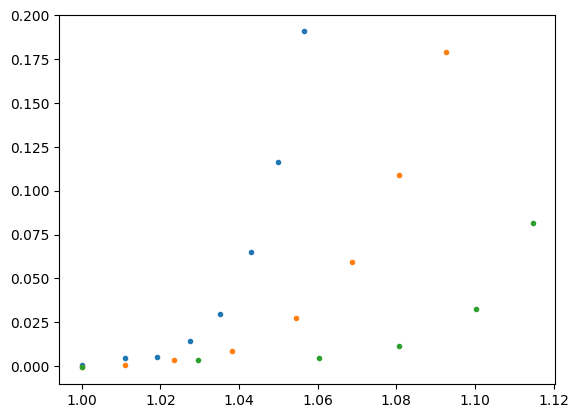

In [6]:
# Plotting the smples with id 4, 5 and 13

for i_sample in [0,1,2]:
    sample_lmx = data[1,data[0,:]==i_sample]
    sample_lmy = data[2,data[0,:]==i_sample]
    sample_sgmx = data[3,data[0,:]==i_sample]
    sample_sgmy = data[4,data[0,:]==i_sample]
    plt.plot(sample_lmy[::10], sample_sgmy[::10], '.')

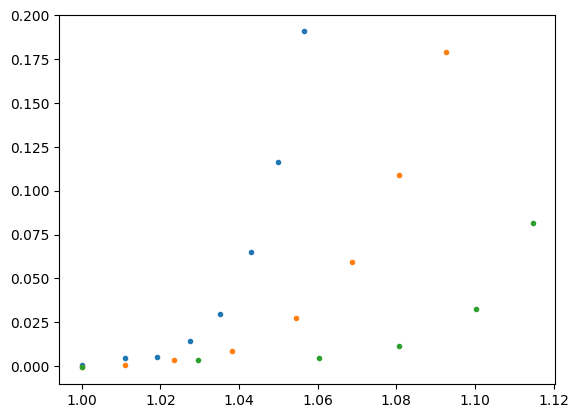

In [7]:
# Plotting the smples with id 4, 5 and 13

for i_sample in [0,1,2]:
    sample_lmx = OffXall[1,OffXall[0,:]==i_sample]
    sample_lmy = OffXall[3,OffXall[0,:]==i_sample]
    sample_sgmx = OffXall[2,OffXall[0,:]==i_sample]
    sample_sgmy = OffXall[4,OffXall[0,:]==i_sample]
    plt.plot(sample_lmy[::10], sample_sgmy[::10], '.')

In [8]:
# ll=[1,2,3,4,5]
# print(ll[::2])

In [9]:
# C1 = C1g + C1 where C1g is common across all specimens
def model(i_sample, lmx, lmy, sgmx_gt=None, sgmy_gt=None):
    mu_g = numpyro.sample('mu_g', dist.Normal(0.01,0.01))
    k1_g = numpyro.sample('k1_g', dist.Normal(1.0,10.0))
    k2_g = numpyro.sample('k2_g', dist.Normal(18.0,5.0))
    kappa_g = numpyro.sample('kappa_g', dist.Normal(0.2,1.0))
    alpha_g = numpyro.sample('alpha_g', dist.Normal(np.pi/6.0,2.0))
    k1_2_g = numpyro.sample('k1_2_g', dist.Normal(2.0,10.0))
    k2_2_g = numpyro.sample('k2_2_g', dist.Normal(2.5,5.0))
    kappa2_g = numpyro.sample('kappa2_g', dist.Normal(1.0,1.0))
    alpha2_g = numpyro.sample('alpha2_g', dist.Normal(np.pi/3.0,2.0))

    with numpyro.plate('pop_plate', n_samples):
        mu_i = numpyro.sample('mu_i', dist.Normal(0.01,0.01))
        k1_i = numpyro.sample('k1_i', dist.Normal(50.0,10.0))
        k2_i = numpyro.sample('k2_i', dist.Normal(6.0,5.0))
        kappa_i = numpyro.sample('kappa_i', dist.Normal(2.0,1.0))
        alpha_i = numpyro.sample('alpha_i', dist.Normal(2.0,2.0))
        k1_2_i = numpyro.sample('k1_2_i', dist.Normal(50.0,10.0))
        k2_2_i = numpyro.sample('k2_2_i', dist.Normal(6.0,5.0))
        kappa2_i = numpyro.sample('kappa2_i', dist.Normal(2.0,1.0))
        alpha2_i = numpyro.sample('alpha2_i', dist.Normal(2.0,2.0))

    noiselevel = numpyro.sample('noiselevel', dist.HalfNormal(1.0))
    lmz = 1.0/(lmx*lmy)
    
    if i_sample is not None:
        mu = mu_g + mu_i[i_sample]
        k1 = k1_g + k1_i[i_sample]
        k2 = k2_g + k2_i[i_sample]
        kappa = kappa_g + kappa_i[i_sample]
        alpha = alpha_g + alpha_i[i_sample]
        k1_2 = k1_2_g + k1_2_i[i_sample]
        k2_2 = k2_2_g + k2_2_i[i_sample]
        kappa2 = kappa2_g + kappa2_i[i_sample]
        alpha2 = alpha2_g + alpha2_i[i_sample]

        params = [mu, k1, k2, kappa, alpha, k1_2, k2_2, kappa2, alpha2]
        sgmx_pr, sgmy_pr = GOH_vmap(params, lmx, lmy, lmz)
    else:
        mu_i = numpyro.sample('mu_a', dist.Normal(0.01,0.01))
        k1_i = numpyro.sample('k1_a', dist.Normal(50.0,10.0))
        k2_i = numpyro.sample('k2_a', dist.Normal(6.0,5.0))
        kappa_i = numpyro.sample('kappa_a', dist.Normal(2.0,1.0))
        alpha_i = numpyro.sample('alpha_a', dist.Normal(2.0,2.0))
        k1_2_i = numpyro.sample('k1_2_a', dist.Normal(50.0,10.0))
        k2_2_i = numpyro.sample('k2_2_a', dist.Normal(6.0,5.0))
        kappa2_i = numpyro.sample('kappa2_a', dist.Normal(2.0,1.0))
        alpha2_i = numpyro.sample('alpha2_a', dist.Normal(2.0,2.0))

        mu = mu_g + mu_i
        k1 = k1_g + k1_i
        k2 = k2_g + k2_i
        kappa = kappa_g + kappa_i
        alpha = alpha_g + alpha_i
        k1_2 = k1_2_g + k1_2_i
        k2_2 = k2_2_g + k2_2_i
        kappa2 = kappa2_g + kappa2_i
        alpha2 = alpha2_g + alpha2_i

        params = [mu, k1, k2, kappa, alpha, k1_2, k2_2, kappa2, alpha2]
        sgmx_pr, sgmy_pr = GOH_vmap2(params, lmx, lmy, lmz)

    with numpyro.plate('data', len(lmx)):
        numpyro.sample('obs1', dist.Normal(sgmx_pr,noiselevel), obs=sgmx_gt)
        numpyro.sample('obs2', dist.Normal(sgmy_pr,noiselevel), obs=sgmy_gt)

In [18]:
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=209, num_warmup=209) # use 20000 and 200000
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, data[0,:].astype(int), data[1,:], data[2,:], data[3,:], data[4,:])

posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 418/418 [00:24<00:00, 16.74it/s, 1023 steps of size 1.29e-03. acc. prob=0.86]


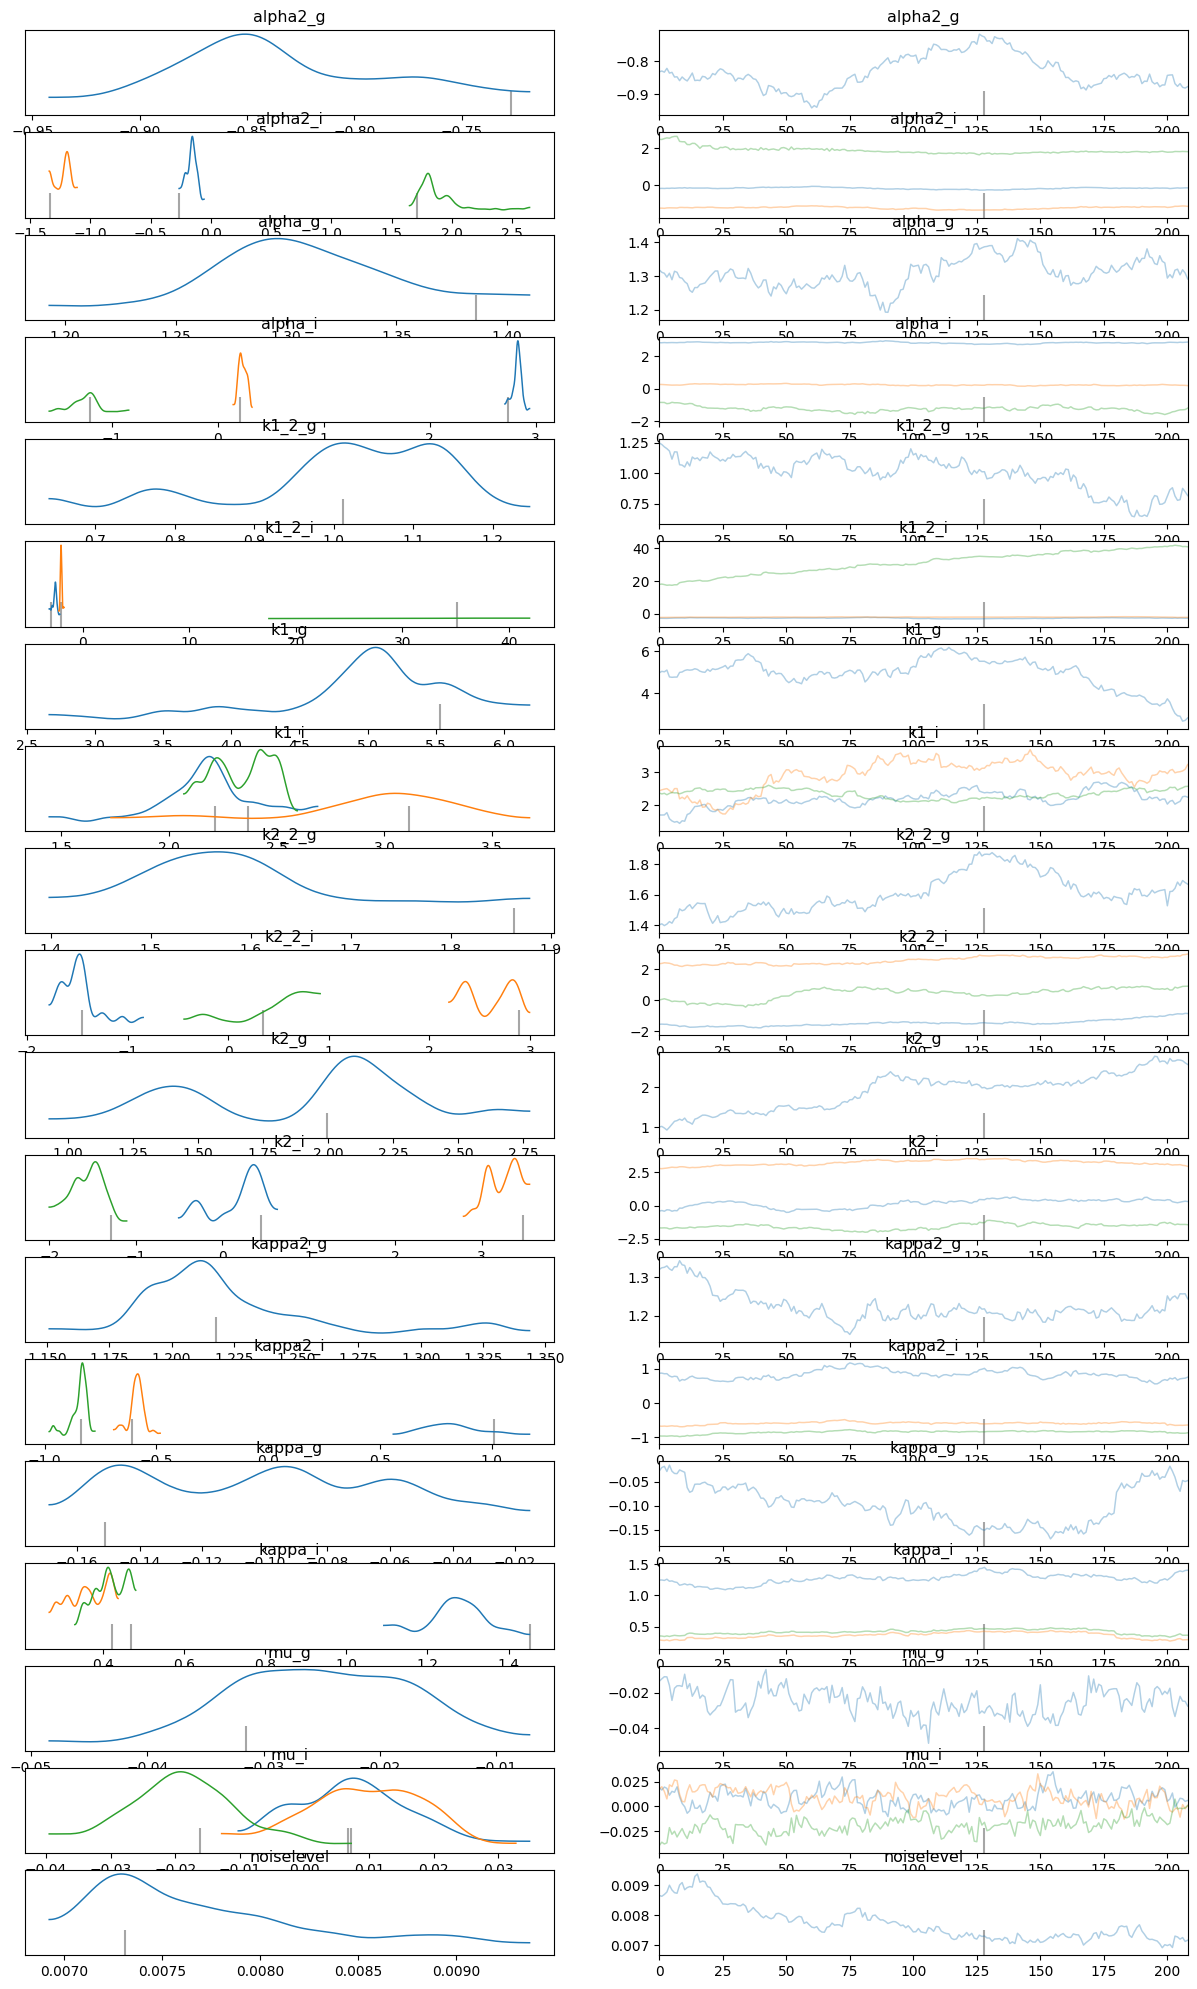

In [19]:
import arviz as az

outdata = az.from_numpyro(mcmc)
az.plot_trace(outdata, compact=True, figsize=(15, 25)); 

In [20]:
predictive = Predictive(model, posterior_samples)
samples_predictive = predictive(random.PRNGKey(1), data[0,:].astype(int), data[1,:], data[2,:], None, None)

In [21]:
# predictive = Predictive(model, posterior_samples)
# samples_predictive = predictive(random.PRNGKey(1), OffXall[0,:].astype(int), OffXall[1,:], OffXall[3,:], None, None)

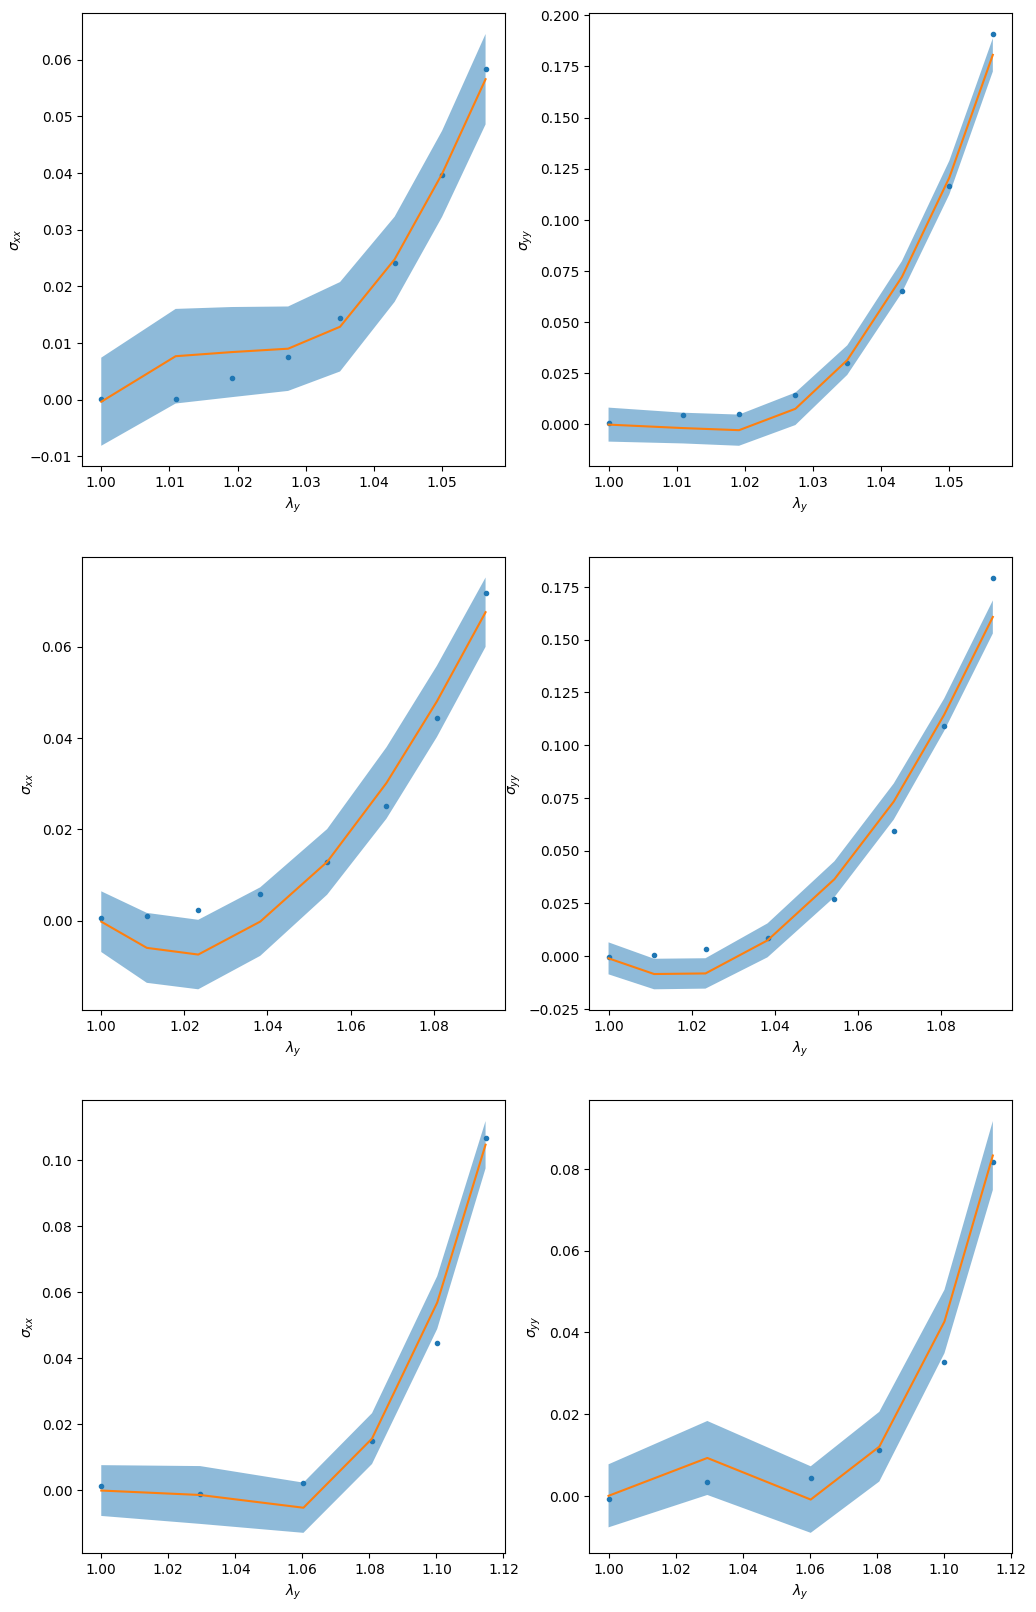

In [22]:
fig, axes = plt.subplots(3,2,figsize=(12,20))

for ax, i_sample in zip(axes, [0,1,2]):
    sgmx_pr = samples_predictive['obs1']
    sgmy_pr = samples_predictive['obs2']    

    idx = data[0,:]==i_sample
    x = data[2,idx]
    # print(x)
    sgmx_gt = data[3,idx] ##sigma real
    sgmx_std = sgmx_pr.std(axis=0)[idx] ##sigma predicted
    sgmx_pr = sgmx_pr.mean(axis=0)[idx]
    sgmx_inf = sgmx_pr-sgmx_std
    sgmx_sup = sgmx_pr+sgmx_std

    ax[0].plot(x[::10],sgmx_gt[::10],'.')
    ax[0].plot(x[::10],sgmx_pr[::10])
    ax[0].fill_between(x[::10], sgmx_sup[::10], sgmx_inf[::10], alpha=0.5)
    ax[0].set(xlabel='$\lambda_y$', ylabel='$\sigma_{xx}$')


    sgmy_gt = data[4,idx]
    sgmy_std = sgmy_pr.std(axis=0)[idx]
    sgmy_pr = sgmy_pr.mean(axis=0)[idx]
    sgmy_inf = sgmy_pr-sgmy_std
    sgmy_sup = sgmy_pr+sgmy_std
    ax[1].plot(x[::10],sgmy_gt[::10],'.')
    ax[1].plot(x[::10],sgmy_pr[::10])
    ax[1].fill_between(x[::10], sgmy_sup[::10], sgmy_inf[::10], alpha=0.5)
    ax[1].set(xlabel='$\lambda_y$', ylabel='$\sigma_{yy}$')

In [16]:
predictive = Predictive(model, posterior_samples)
samples_predictive2 = predictive(random.PRNGKey(1), None, data[1,:], data[2,:], None, None)

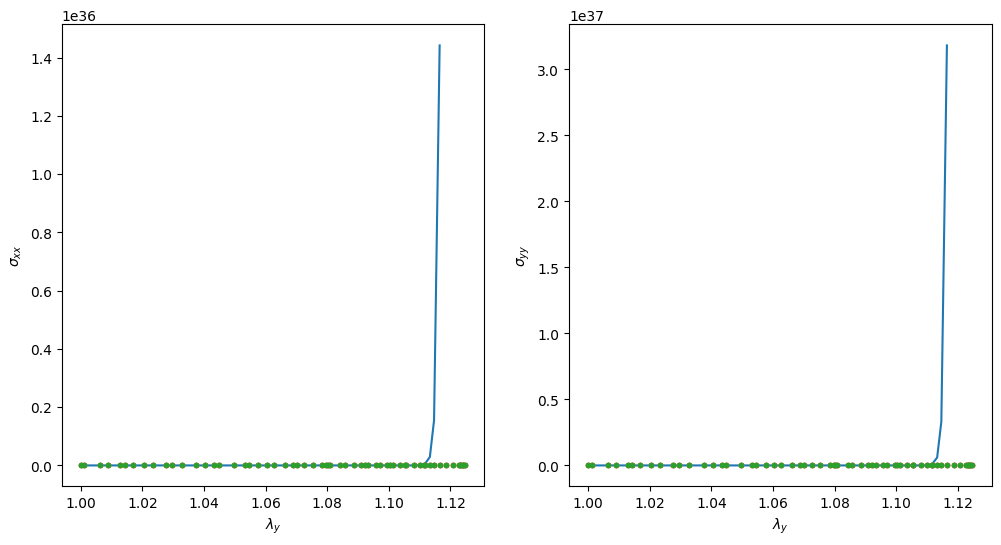

In [42]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

sgmx_pr = samples_predictive2['obs1'] # predicted P11 value
sgmy_pr = samples_predictive2['obs2'] # predicted P22 value

idx = data[0,:]==i_sample # idx is the vector that contains all data points from the same i_sample (sample id)
x = data[2,idx] # all the lam1 values from the same sample
sgmx_gt = data[3,idx] # all the P11 values from the same sample
sgmx_std = sgmx_pr.std(axis=0)[idx] # std of predicted P11
sgmx_pr = sgmx_pr.mean(axis=0)[idx] # mean value of predicted P11
sgmx_inf = sgmx_pr-sgmx_std*2 # lower bound CI
sgmx_sup = sgmx_pr+sgmx_std*2 # upper bound CI

ax[0].plot(x,sgmx_gt,'.', color='0') # plot real data P11 vs lam1
ax[0].plot(x,sgmx_pr) # plot predicted P11 vs lam1
# ax[0].fill_between(x[::10], sgmx_sup[::10], sgmx_inf[::10], alpha=0.5) # Fill CI
ax[0].set(xlabel='$\lambda_y$', ylabel='$\sigma_{xx}$')

sgmy_gt = data[4,idx] # all the P22 values from the same sample
sgmy_std = sgmy_pr.std(axis=0)[idx] # std of predicted P22
sgmy_pr = sgmy_pr.mean(axis=0)[idx] # mean value of predicted P22
sgmy_inf = sgmy_pr-sgmy_std*2
sgmy_sup = sgmy_pr+sgmy_std*2

ax[1].plot(x,sgmy_gt,'.', color='0')
ax[1].plot(x[0:-5],sgmy_pr[0:-5])
# ax[1].fill_between(x[::10], sgmy_sup[::10], sgmy_inf[::10], alpha=0.5)
ax[1].set(xlabel='$\lambda_y$', ylabel='$\sigma_{yy}$')

for i_sample in range(n_samples):
    idx = data[0,:]==i_sample
    sgmx_gt = data[3,idx]
    sgmy_gt = data[4,idx]
    if len(x)<len(sgmx_gt):
        ax[0].plot(x,sgmx_gt[0:len(x)],'.')
        ax[1].plot(x,sgmy_gt[0:len(x)],'.')
    elif len(x)>len(sgmx_gt):
        ax[0].plot(x[0:len(sgmx_gt)],sgmx_gt,'.')
        ax[1].plot(x[0:len(sgmy_gt)],sgmy_gt,'.')